<a href="https://colab.research.google.com/github/amsmith123/Time-Series-Forecasting-Store-Sales/blob/main/Store_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'store-sales-time-series-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F29781%2F2887556%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240205%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240205T181829Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8365f9d727c383b8dafdb5353cfd040f9d810817fd1fa47574f4ed66f235ac50391f244f72c65e272b1631055e7b1d15f93289afd8aeb827584a9a12e9088a31f7eb8fcbe070b93a0d105999da363911cabbc753b0036684d81b16114de2ffccd46591d3680e6a9c8e109a4dabf9c53362f162b12180e584d2a5669bf961e50c5462bfe05a18ea5ff961677526edc5473530c1e31ac7d5cf7525f66caefda3de4901620da30b648d73cc20fc3cd840e1984004a1438350842463cbf69fa3d27aa90d77e185f35dabf5740de6afce30ba49781f3a272b2089a1a9a234d6a37116197842d1aad4e7121da5a090a2407520f4c59235c0267d206435f5929f77e00f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22416355 bytes downloaded
Downloaded and uncompressed: store-sales-time-series-forecasting
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv


# Loading the data

Load data into dataframes

In [3]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_hol_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

Merge data

In [4]:
# Merge training dataframes
df_train = df_train.merge(df_stores, on='store_nbr', how='left')
df_train = df_train.merge(df_oil, on='date', how='left')
df_train = df_train.merge(df_hol_events, on='date', how='left')
df_train = df_train.rename(columns={'type_x': 'store_type','type_y':'holiday_type'})
# df_combined = df_combined.merge(df_transactions, on='store_nbr', how='inner')

# Merge test dataframes
df_test = df_test.merge(df_stores, on='store_nbr', how='left')
df_test = df_test.merge(df_oil, on='date', how='left')
df_test = df_test.merge(df_hol_events, on='date', how='left')
df_test = df_test.rename(columns={'type_x': 'store_type','type_y':'holiday_type'})
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   store_type    object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28512 non-null  int64  
 1   date          28512 non-null  object 
 2   store_nbr     28512 non-null  int64  
 3   family 

Look for correlation between Oil Prices vs Sales

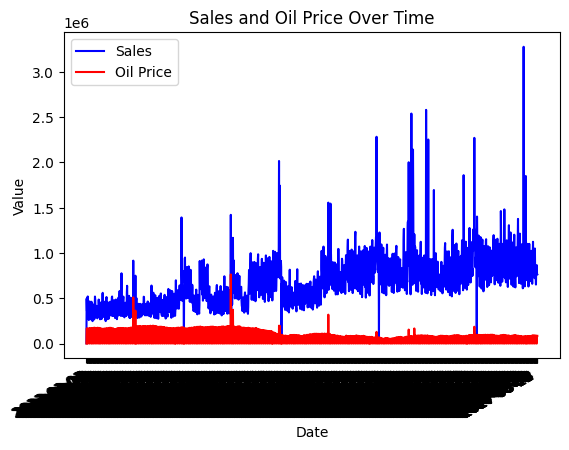

In [5]:
import matplotlib.dates as mdates
sales_by_date = df_train.groupby(by='date')['sales'].sum().reset_index()
sales_by_date = sales_by_date.sort_values('date')
oil_by_date = df_train.groupby(by='date')['dcoilwtico'].sum().reset_index()
oil_by_date = oil_by_date.sort_values('date')

plt.plot(sales_by_date['date'], sales_by_date['sales'], marker='', linestyle='-', color='b', label='Sales', zorder=1)
plt.plot(oil_by_date['date'], oil_by_date['dcoilwtico'], marker='', linestyle='-', color='r', label='Oil Price', zorder=2)
plt.title('Sales and Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Filter out non-relevant holidays from training data (remove hollidays that do not occur in the same location as the store)

In [6]:
holiday_data = df_train[df_train['holiday_type'].notna()]
print(len(list(holiday_data['holiday_type'])))
holiday_data = df_train[
    (df_train['holiday_type'] == 'Holiday')
    & ((df_train['locale'] == 'National')
        | (df_train['locale_name'] == df_train['city'])
        | ((df_train['locale'] == 'Regional') & (df_train['locale_name'] == df_train['state'])))]
print(len(list(holiday_data['holiday_type'])))
print(holiday_data.info())

502524
93225
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93225 entries, 0 to 3052763
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            93225 non-null  int64  
 1   date          93225 non-null  object 
 2   store_nbr     93225 non-null  int64  
 3   family        93225 non-null  object 
 4   sales         93225 non-null  float64
 5   onpromotion   93225 non-null  int64  
 6   city          93225 non-null  object 
 7   state         93225 non-null  object 
 8   store_type    93225 non-null  object 
 9   cluster       93225 non-null  int64  
 10  dcoilwtico    56001 non-null  float64
 11  holiday_type  93225 non-null  object 
 12  locale        93225 non-null  object 
 13  locale_name   93225 non-null  object 
 14  description   93225 non-null  object 
 15  transferred   93225 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 12.1+ MB
None


Filter holidays for test data

In [7]:
holiday_data_test = df_test[df_test['holiday_type'].notna()]
print(len(list(holiday_data_test['holiday_type'])))
holiday_data_test = df_test[
    (df_test['holiday_type'] == 'Holiday')
    & ((df_test['locale'] == 'National')
        | (df_test['locale_name'] == df_test['city'])
        | ((df_test['locale'] == 'Regional') & (df_test['locale_name'] == df_test['state'])))]
print(len(list(holiday_data_test['holiday_type'])))
print(holiday_data_test.info())

1782
66
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 14751 to 15773
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            66 non-null     int64  
 1   date          66 non-null     object 
 2   store_nbr     66 non-null     int64  
 3   family        66 non-null     object 
 4   onpromotion   66 non-null     int64  
 5   city          66 non-null     object 
 6   state         66 non-null     object 
 7   store_type    66 non-null     object 
 8   cluster       66 non-null     int64  
 9   dcoilwtico    66 non-null     float64
 10  holiday_type  66 non-null     object 
 11  locale        66 non-null     object 
 12  locale_name   66 non-null     object 
 13  description   66 non-null     object 
 14  transferred   66 non-null     object 
dtypes: float64(1), int64(4), object(10)
memory usage: 8.2+ KB
None


Merge the holiday information back to the train and test data

In [8]:
holiday_data_filtered = holiday_data[["id"]]
holiday_data_filtered.loc[:,"holiday"] = 1
holiday_data_test_filtered = holiday_data_test[["id"]]
holiday_data_test_filtered.loc[:,"holiday"] = 1
df_train = df_train.merge(holiday_data_filtered,on='id',how='left')
df_test = df_test.merge(holiday_data_test_filtered,on='id', how='left')
print(df_train['holiday'].info())

<ipython-input-8-4d9ac7877baf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_data_filtered.loc[:,"holiday"] = 1
<ipython-input-8-4d9ac7877baf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_data_test_filtered.loc[:,"holiday"] = 1


<class 'pandas.core.series.Series'>
Int64Index: 3054414 entries, 0 to 3054413
Series name: holiday
Non-Null Count  Dtype  
--------------  -----  
99594 non-null  float64
dtypes: float64(1)
memory usage: 46.6 MB
None


# Prepare data

Remove unneccessary columns.

In [9]:
df_train = df_train.drop(['holiday_type', 'locale','locale_name','description','transferred'], axis=1)
df_test = df_test.drop(['holiday_type', 'locale','locale_name','description','transferred'], axis=1)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054414 entries, 0 to 3054413
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   store_type   object 
 9   cluster      int64  
 10  dcoilwtico   float64
 11  holiday      float64
dtypes: float64(3), int64(4), object(5)
memory usage: 302.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           28512 non-null  int64  
 1   date         28512 non-null  object 
 2   store_nbr    28512 non-null  int64  
 3   family       28512 non-null  object 
 4   onpromotion  28512 non-null  int64  
 5   city         28512 non-null  object 
 6   stat

One-Hot Encode Categorical Columns

In [10]:
# Columns to encode
columns_to_encode = ['family', 'city', 'state', 'store_type']
# One-hot encode these columns in the training data
train_encoded = pd.get_dummies(df_train, columns=columns_to_encode)

# One-hot encode these columns in the testing data
test_encoded = pd.get_dummies(df_test, columns=columns_to_encode)

# Get the list of columns from the training data
encoded_columns = train_encoded.columns

# Ensure the columns of the test data match the training data
# Missing columns in the test set are added as zeros
for column in encoded_columns:
    if column not in test_encoded and column != 'sales':
        test_encoded[column] = 0

# Ensure the order of columns in the test set matches the training set
#test_encoded = test_encoded[encoded_columns]

# If there are extra columns in the test set that are not in the training set, drop them
extra_columns = set(test_encoded.columns) - set(encoded_columns)
if extra_columns:
    test_encoded = test_encoded.drop(columns=extra_columns)

# Convert date column to numerical year, month, day, day of week columns
train_encoded['date'] = pd.to_datetime(train_encoded['date'], format='%Y-%m-%d')
test_encoded['date'] = pd.to_datetime(test_encoded['date'], format='%Y-%m-%d')

train_encoded['year'] = train_encoded['date'].dt.year
train_encoded['month'] = train_encoded['date'].dt.month
train_encoded['day'] = train_encoded['date'].dt.day
train_encoded['dayofweek'] = train_encoded['date'].dt.dayofweek
test_encoded['year'] = test_encoded['date'].dt.year
test_encoded['month'] = test_encoded['date'].dt.month
test_encoded['day'] = test_encoded['date'].dt.day
test_encoded['dayofweek'] = test_encoded['date'].dt.dayofweek

train_encoded = train_encoded.drop(['date','id'], axis=1)
test_encoded = test_encoded.drop(['date','id'], axis=1)

Data Normalization Using Min-Max Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

target = train_encoded['sales']
train_encoded = train_encoded.drop(['sales'],axis=1)

sc = MinMaxScaler(feature_range = (0,1))
target_sc = MinMaxScaler(feature_range = (0,1))
training_data_scaled = sc.fit_transform(train_encoded)
target_scaled = target_sc.fit_transform(target.values.reshape(-1, 1))
training_data_scaled.shape

(3054414, 85)

Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data_scaled, target_scaled, test_size=0.2, random_state=42)

# Build and Train the Model

Create the model architecture

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Neural Network implementation with 3 Linear hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

Convert data into tensors for training

In [14]:
# Convert to PyTorch tensors
X_train = np.nan_to_num(X_train, nan=0.0)
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()

X_val = np.nan_to_num(X_val, nan=0.0)
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()

# Create datasets and data loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=False)

Initalize model weights using Xavier initialization

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Train the model

In [16]:
# Define model parameters
input_size = 85
output_size = 1
val_loss_best=1
learning_rate = 0.0001
num_epochs = 50

# Instantiate model
model = NeuralNetwork(input_size, output_size)
model.apply(init_weights)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function - RMSLE
def rmsle_loss(y_pred, y_true):
    # Ensure that predictions and labels are all positive and nonzero
    y_pred = torch.clamp(y_pred, min=1e-10)
    y_true = torch.clamp(y_true, min=1e-10)

    # Take the Logarithm
    log_y_pred = torch.log(y_pred)
    log_y_true = torch.log(y_true)

    # Calculate the squared log error
    squared_log_error = (log_y_pred - log_y_true) ** 2

    # Calculate the mean of the squared log error and take the square root
    mean_squared_log_error = torch.mean(squared_log_error)
    loss = torch.sqrt(mean_squared_log_error)
    return loss

for epoch in range(num_epochs):
    # Set model to training mode and train with the training set

    model.train()
    train_loss = 0
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = rmsle_loss(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}', end = '\t\t\t\t')
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Set model to evaluation mode and test with validation data

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_features, val_labels in val_loader:
            # Forward pass
            val_outputs = model(val_features)
            # Calculate loss
            batch_loss = rmsle_loss(val_outputs, val_labels)
            val_loss += batch_loss.item()

        # Average the validation loss
        val_loss /= len(val_loader)

    # Print training and validation loss for each epoch, save model if validation loss reaches lowest value
    print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train_Loss: {loss.item()}, Val_Loss = {val_loss}')
    if val_loss < val_loss_best:
        torch.save(model, 'model.pth')
        val_loss_best = val_loss

Epoch [1/50], Step [38181/38181], Train_Loss: 4.861000061035156, Val_Loss = 3.053900422657662
Epoch [2/50], Step [38181/38181], Train_Loss: 1.9104530811309814, Val_Loss = 2.830978377091679
Epoch [3/50], Step [38181/38181], Train_Loss: 3.860786199569702, Val_Loss = 2.737583511278207
Epoch [4/50], Step [38181/38181], Train_Loss: 0.9673414826393127, Val_Loss = 2.651213358651973
Epoch [5/50], Step [38181/38181], Train_Loss: 3.7751431465148926, Val_Loss = 2.5777797351028475
Epoch [6/50], Step [38181/38181], Train_Loss: 2.4289872646331787, Val_Loss = 2.5034773182712224
Epoch [7/50], Step [38181/38181], Train_Loss: 3.184575080871582, Val_Loss = 2.4727015219256887
Epoch [8/50], Step [38181/38181], Train_Loss: 2.125272750854492, Val_Loss = 2.4474699338134602
Epoch [9/50], Step [38181/38181], Train_Loss: 1.6846610307693481, Val_Loss = 2.391352779982595
Epoch [10/50], Step [38181/38181], Train_Loss: 1.5390253067016602, Val_Loss = 2.3781408488884708
Epoch [11/50], Step [38181/38181], Train_Loss: 2

Evaluate the model using Root Mean Squared Log Error

In [18]:
from sklearn.metrics import mean_squared_log_error

# Load the best model
#model = torch.load('model.pth')

X_val = np.nan_to_num(X_val, nan=0.0)
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()

# Make predictions on validation data to calculate Root Mean Squared Log Error
with torch.no_grad():
    model.eval()
    predictions = model(X_val_tensor)
    predictions = target_sc.inverse_transform(predictions.numpy())
    actuals = target_sc.inverse_transform(y_val_tensor.numpy())

# Calculate RMSLE
# Add a small constant as log(0) is not defined
rmsle = np.sqrt(mean_squared_log_error(actuals, np.maximum(0, predictions)))
print(f'RMSLE: {rmsle}')

RMSLE: 0.5147320628166199


Print statistical summary of actual vs predicted outputs of val data

In [19]:
data = pd.DataFrame({'Actual': actuals[:,0], 'Prediction': predictions[:,0]})
print(data.describe())

              Actual     Prediction
count  610883.000000  610883.000000
mean      357.403320     358.939880
std      1105.589722    1094.198853
min         0.000000       0.000000
25%         0.000000       0.000022
50%        11.000000       9.205843
75%       195.526505     198.921860
max     89576.359375   23865.511719


# Make predictions and create submission file

In [20]:

X_test = sc.transform(test_encoded)
X_test = np.nan_to_num(X_test, nan=0.0)
X_test_tensor = torch.tensor(X_test).float()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    preds = model(X_test_tensor)
    preds = target_sc.inverse_transform(preds.numpy())

submission = pd.DataFrame({
    'id': df_test['id'],  # Assuming df_test has an 'id' column
    'sales': preds.ravel()  # Convert 2D array to 1D
})

# Output the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

        id         sales
0  3000888  3.091428e+00
1  3000889  1.737973e-06
2  3000890  5.477537e+00
3  3000891  2.071333e+03
4  3000892  6.779166e-19


Public RMSLE Score on Kaggle: 0.53631